In [21]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate, ZGate, IGate
from qiskit.quantum_info import Statevector

import itertools

In [22]:
# Dictionary of supported code tableaus
tableau_dict = {
    "steane": [
        [XGate,XGate,XGate,XGate,IGate,IGate,IGate],
        [IGate,XGate,XGate,IGate,IGate,XGate,XGate],
        [XGate,IGate,XGate,IGate,XGate,IGate,XGate],
        [ZGate,ZGate,ZGate,ZGate,IGate,IGate,IGate],
        [IGate,ZGate,ZGate,IGate,IGate,ZGate,ZGate],
        [ZGate,IGate,ZGate,IGate,ZGate,IGate,ZGate],
    ]
}

In [24]:
# Function which generates an encoding circuit for a given tableau
def generate_encoding_circuit(tableau):
    # The number of qubits is equal to the length of any stabilizer
    n_qubits = len(tableau[0])
    encoding_circuit = QuantumCircuit(n_qubits)

    # Method from Gottesman's paper; applies every combination of every length of stabilizers
    for length in range(len(tableau) + 1):
        for stabilizer_combination in itertools.combinations(tableau, length):
            for stabilizer in stabilizer_combination:
                for qubit, operation in enumerate(stabilizer):
                    encoding_circuit.append(operation(), [qubit])
 
    return encoding_circuit

In [25]:
encoding_circuit = generate_encoding_circuit(tableau_dict["steane"])
print("Number of gates:", sum(encoding_circuit.count_ops().values()))

Number of gates: 1344


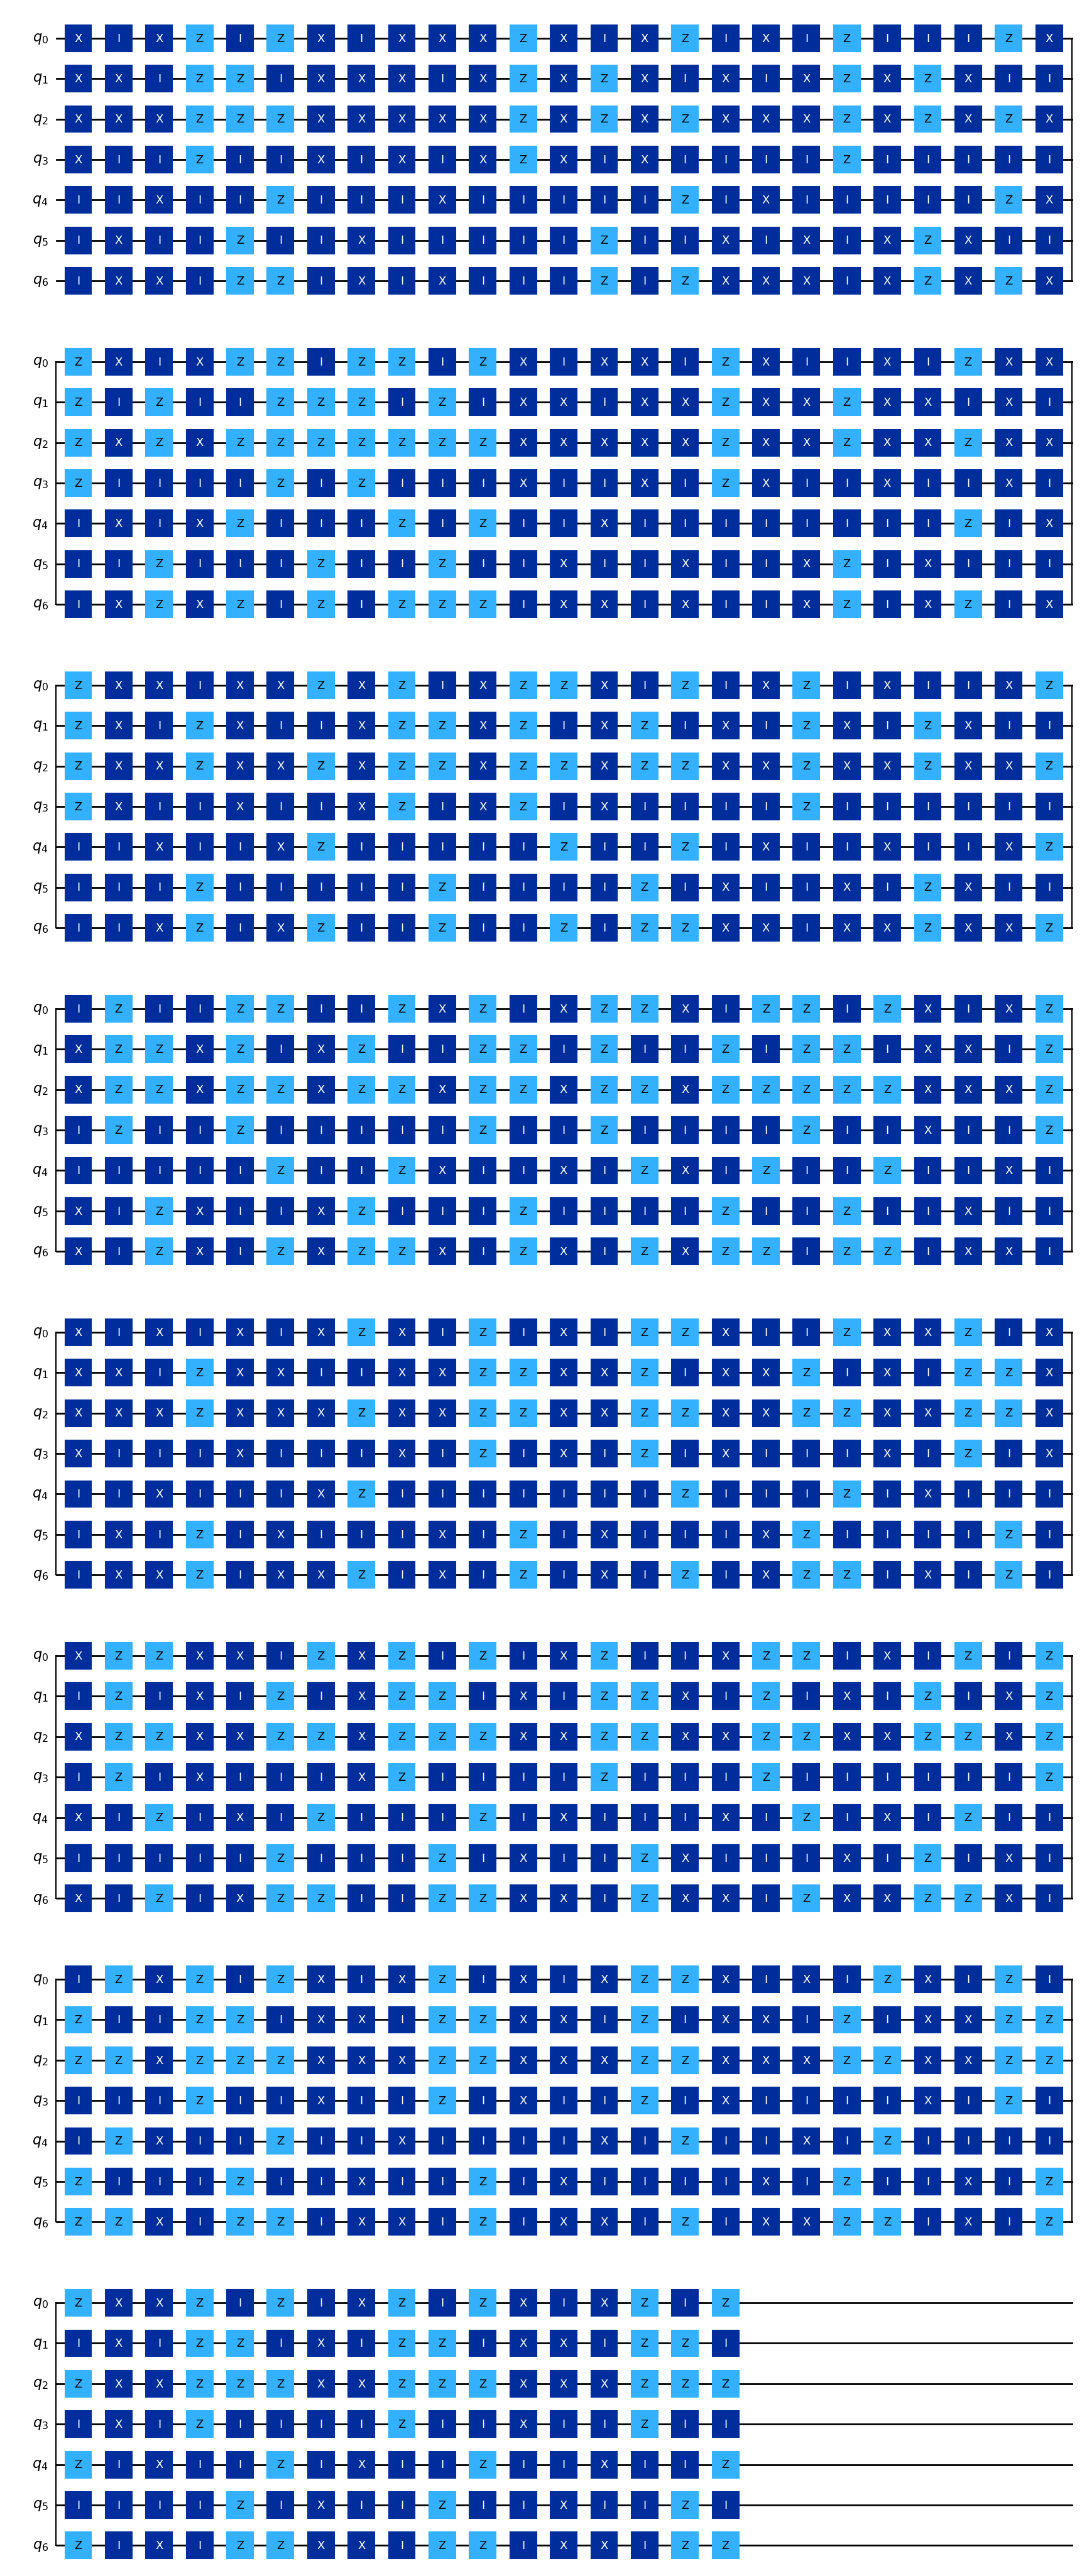

In [26]:
encoding_circuit.draw('mpl')

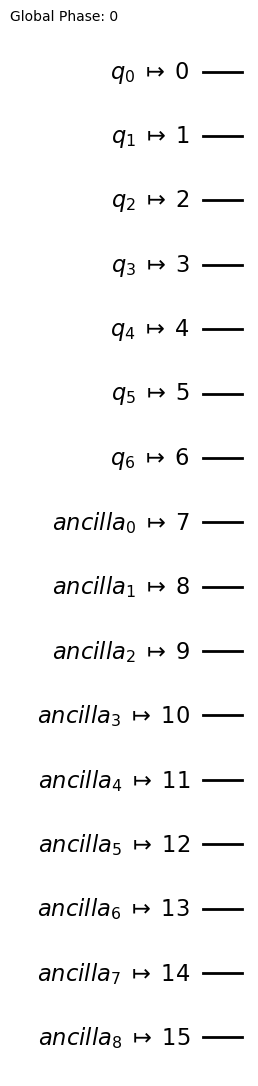

In [28]:
from qiskit import transpile
from qiskit.providers.fake_provider import GenericBackendV2

backend = GenericBackendV2(16)

transpiled_encoding_circuit = transpile(encoding_circuit, backend, optimization_level=1)
transpiled_encoding_circuit.draw('mpl')

In [29]:
# Draw the state encoded by the circuit
encoded_state = Statevector.from_instruction(encoding_circuit)
encoded_state.draw('latex')

<IPython.core.display.Latex object>